# Preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

import warnings

warnings.filterwarnings('ignore')

Пропишем требуемые пути и откроем данные

In [2]:
cwd = os.getcwd()

PATH_SALES_DF_TRAIN = cwd + '/data/raw/sales_df_train.csv'
PATH_PR_DF = cwd + '/data/raw/pr_df.csv'
PATH_ST_DF = cwd + '/data/raw/st_df.csv'

PATH_TO_SAVE_HOLIDAYS = cwd + '/data/holidays.csv'

PATH_TO_SAVE_CLEAR_TRAIN_DF = cwd + '/data/preprocessing/clear_sales_df_train.csv'

PATH_TO_SAVE_SALES_TRAIN_DF = cwd + '/data/preprocessing/preproc_sales_df_train.csv'
PATH_TO_SAVE_ST_DF = cwd + '/data/preprocessing/preproc_st_df.csv'
PATH_TO_SAVE_PR_DF = cwd + '/data/preprocessing/preproc_pr_df.csv'
PATH_TO_SAVE_TRAIN_DF = cwd + '/data/preprocessing/preproc_df_train.csv'

PATH_TO_SAVE_SALES_TRAIN_DF_NO_OTLIERS = cwd + '/data/preprocessing/preproc_sales_df_train_no.csv'
PATH_TO_SAVE_TRAIN_DF_NO_OTLIERS = cwd + '/data/preprocessing/preproc_df_train_no.csv'

PATH_TO_SAVE_TEST_DF = cwd + '/data/preprocessing/preproc_df_test.csv'
PATH_TO_SAVE_TEST_DF_NO_OTLIERS = cwd + '/data/preprocessing/preproc_df_test_no.csv'

In [3]:
sales_df_train = pd.read_csv(PATH_SALES_DF_TRAIN)
pr_df = pd.read_csv(PATH_PR_DF)
st_df = pd.read_csv(PATH_ST_DF)

In [4]:
sales_df_train

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,5.0,5.0,825.0,825.0
1,42a0e188f5033bc65bf8d78622277c4e,68f441429e73dbd33b81f95da31576e9,2023-01-29,0,4.0,0.0,196.0,0.0
2,1ecfb463472ec9115b10c292ef8bc986,22988026fe85fde60d8bf777ab6bc3b4,2023-03-02,0,1.0,0.0,78.0,0.0
3,42a0e188f5033bc65bf8d78622277c4e,8e887cf8e64ab8e7173701a979476567,2023-04-05,1,0.0,0.0,69.0,69.0
4,16a5cdae362b8d27a1d8f8c7b78b4330,e6fc24ca846339d204b0b50e9f772484,2023-02-17,0,1.0,0.0,161.0,0.0
...,...,...,...,...,...,...,...,...
883010,c81e728d9d4c2f636f067f89cc14862c,a0150fefa71d6606d5e642fa0e7b8ad8,2022-12-13,1,1.0,1.0,33.0,33.0
883011,42a0e188f5033bc65bf8d78622277c4e,5b146d93f822459260216df28e572eca,2023-04-18,0,1.0,0.0,192.0,0.0
883012,42a0e188f5033bc65bf8d78622277c4e,c8bd18ea08d2f47cb0a7992f11ada9de,2022-08-16,0,5.0,0.0,970.0,0.0
883013,f7e6c85504ce6e82442c770f7c8606f0,b960c6ee5b5efa12e73f810204b561a8,2023-04-23,0,4.0,0.0,262.0,0.0


Поскольку предсказывать будем только общее количество продаж товара(pr_sales_in_units), то в датасете sales_df_train оставим только столбцы st_id, pr_sku_id (для джойна с другими датасетами), столбец с датой date и целевой признок pr_sales_in_units

In [5]:
sales_df_train = sales_df_train[['st_id', 'pr_sales_type_id', 'pr_sku_id', 'date', 'pr_sales_in_units']]

## Предообработка данных по товарам

Согласно EDA нам необходимо сделать метку для отнесения товара к той или иной категории, согласно динамике цен на них добавим такой столбец в датасет pr_df. Создадим соответствующую функцию.

In [6]:
def get_cat(df):
    df.loc[df['pr_cat_id']=='c559da2ba967eb820766939a658022c8', 'group_cat'] = 'cat_1'
    df.loc[df['pr_subcat_id']=='60787c41b04097dfea76addfccd12243', 'group_cat'] = 'cat_2'
    df.loc[df['pr_subcat_id']=='ca34f669ae367c87f0e75dcae0f61ee5', 'group_cat'] = 'cat_3'
    df.loc[df['pr_cat_id'].isin(['e58cc5ca94270acaceed13bc82dfedf7', 
                                          'fb2fcd534b0ff3bbed73cc51df620323']), 'group_cat'] = 'cat_4'
    df.loc[df['pr_cat_id'].isin(['3de2334a314a7a72721f1f74a6cb4cee', 
                                          'f3173935ed8ac4bf073c1bcd63171f8a',
                                          'b59c67bf196a4758191e42f76670ceba']), 'group_cat'] = 'cat_5'
    df.loc[df['pr_cat_id'].isin(['28fc2782ea7ef51c1104ccf7b9bea13d', 
                                          '9701a1c165dd9420816bfec5edd6c2b1', 
                                          '5caf41d62364d5b41a893adc1a9dd5d4', 
                                          '186a157b2992e7daed3677ce8e9fe40f', 
                                          '2df45244f09369e16ea3f9117ca45157', 
                                          '6d9c547cf146054a5a720606a7694467', 
                                          '535ab76633d94208236a2e829ea6d888', 
                                          'a6ea8471c120fe8cc35a2954c9b9c595']), 'group_cat'] = 'cat_6'
    df.loc[df['pr_cat_id']=='f9ab16852d455ce9203da64f4fc7f92d', 'group_cat'] = 'cat_7'
    df.loc[df['pr_cat_id'].isin(['b7087c1f4f89e63af8d46f3b20271153', 
                                          'f93882cbd8fc7fb794c1011d63be6fb6']), 'group_cat'] = 'cat_8'
    df.loc[df['pr_cat_id']=='faafda66202d234463057972460c04f5', 'group_cat'] = 'cat_9'
    df.loc[df['pr_cat_id']=='fd5c905bcd8c3348ad1b35d7231ee2b1', 'group_cat'] = 'cat_10'
    df.loc[df['pr_cat_id']=='c9f95a0a5af052bffce5c89917335f67', 'group_cat'] = 'cat_11'
    df['group_cat'] = df['group_cat'].fillna('cat_12')
    df['pr_uom_id'] = df['pr_uom_id']==1
    df = df.drop(['pr_cat_id', 'pr_subcat_id'], axis=1) #df['pr_uom_id']
    return df

In [7]:
pr_df = get_cat(pr_df)

Переименуем столбец

In [8]:
pr_df.head()

,pr_sku_id,pr_group_id,pr_uom_id,group_cat
0,fd064933250b0bfe4f926b867b0a5ec8,c74d97b01eae257e44aa9d5bade97baf,False,cat_3
1,71c9661741caf40a92a32d1cc8206c04,c74d97b01eae257e44aa9d5bade97baf,False,cat_1
2,00b72c2f01a1512cbb1d3f33319bac93,c74d97b01eae257e44aa9d5bade97baf,False,cat_12
3,9bc40cd2fe4f188f402bb41548c5e15c,c74d97b01eae257e44aa9d5bade97baf,False,cat_3
4,3a74a370c8eb032acb11ad9119242b8f,c74d97b01eae257e44aa9d5bade97baf,False,cat_1


Сохраним получившийся датасет

In [9]:
pr_df.to_csv(PATH_TO_SAVE_PR_DF, index=False)

Присоединим получившийся датасет к исходным данным

In [10]:
sales_df_train = sales_df_train.merge(pr_df, on ='pr_sku_id')

## Предообработка данных по продажам

Создадим функцию, которая почистит данные, восстановит пропуски в датах и заполнит их нулями (решать будем через словрь)

In [11]:
def get_clear_df(df):
    dict_df = {}     
    df_date = pd.DataFrame(data=df['date'].copy(deep=True).unique(), columns=['date'])
    df = df.copy(deep=True)
    df['all_st_pr'] =  df['st_id'] + '_' + df['pr_sku_id']
    for x in tqdm(df['all_st_pr'].unique()):
        new_df = df.loc[df['all_st_pr']==x].copy(deep=True)
        
        # оставим в датасете только значения с целевым признаком больше или равных 0
        new_df = new_df[new_df['pr_sales_in_units']>=0].reset_index(drop=True)
        
        #сделаем словарь для заполнения пропусков
        list_col = list(new_df.columns)
        list_col.remove('pr_sales_in_units')
        dict_for_fillna = {k: new_df.loc[0, k] for k in list_col}
        
        new_df = new_df.merge(df_date, on='date', how='right')
            
        for k, v in dict_for_fillna.items():
            new_df[k] = new_df[k].fillna(v)
                
        new_df['pr_sales_in_units'] = new_df['pr_sales_in_units'].fillna(0)
        new_df = new_df.sort_values('date')
        new_df = new_df.drop('all_st_pr', axis=1)
        dict_df[x] = new_df
    
    return pd.concat(dict_df.values(),axis=0).sort_values(['date','st_id', 'pr_sku_id'])

In [12]:
sales_df_train = get_clear_df(sales_df_train)

100%|██████████████████████████████████████████████████████████████████████████████| 6244/6244 [04:14<00:00, 24.54it/s]


In [13]:
sales_df_train.to_csv(PATH_TO_SAVE_CLEAR_TRAIN_DF, index=False)

Создадим функцию, которая будет группировать данные по уникальным сочитаниям даты, id магазина и категории товара, для тренировочного датасета и по сочетаниям даты, id магазина и id товара для тестовых

In [14]:
def get_group_and_agg(df, is_train=True):
    #укажем столбцы для группировки и проведём аггрегацию данных
    if is_train:
        group_column = ['st_id', 'group_cat', 'pr_sales_type_id', 'pr_uom_id']
    else:
        group_column = ['st_id', 'pr_sku_id', 'pr_sales_type_id', 'pr_uom_id']
        
    df = (df.groupby(['date', *group_column])['pr_sales_in_units']
                       .agg('mean')
                       .reset_index(drop=False)
                       .sort_values(['date', *group_column]))       
    if is_train:
        df['group_column'] = df['st_id'] + '_' + df['group_cat'] + '_' + df['pr_sales_type_id'].astype('str')
    else:
        df['group_column'] = df['st_id'] + '_' + df['pr_sku_id'] + '_' + df['pr_sales_type_id'].astype('str')
    return df 

Напишем функцию, которая привёдт дату к нормальному формату и выделит ряд некоторые признаки

In [15]:
def get_date_and_weekday(df):
    #приведём дату в нужный формат, укажем новый индекс и день недели
    df['date'] = pd.to_datetime(df['date'])
    df.index = df['date']
    df['weekday'] = df['date'].dt.weekday 
    df = df.drop('date', axis=1)
    df['weekend'] = (df['weekday'] == 5) | (df['weekday'] == 6)
    for i in range(7):
        df[f'weekday_{i}'] = df['weekday']==i
    return df

Поскольку данных много и для данных для предсказаний функции извлечения признаков на полном датасете будут работать долго, то создадим функцию для создания словаря датасетов, что значительно увеличит скорость работы.

In [16]:
def get_dict(df, group_column):
    dict_df = {}     
    for x in df[group_column].unique():
        new_df = df.loc[df[group_column]==x].copy(deep=True).reset_index(drop=True)
        dict_df[x] = new_df
    return dict_df

Нам необходимо почистить данные от выбросов в качеств определяющего значения будем брать отношение текущего значени продаж к скользящему среднему за 30 дней. Чтобы определить порог выброса построим график

In [17]:
df_ts = get_group_and_agg(sales_df_train)
dict_df = get_dict(df_ts, 'group_column')
for name_df in dict_df:
    df = dict_df[name_df].copy(deep=True)
    df = get_date_and_weekday(df)
    dict_df[name_df] = df

In [18]:
new_dict={}
for df_name in dict_df:
    df_date = dict_df[df_name].copy(deep=True)
    new_name_mean = 'rolling_mean_30'
    df_date[new_name_mean] = (df_date['pr_sales_in_units']
                                           .shift()
                                           .rolling(30)
                                           .mean())
    df_date = df_date[['pr_sales_in_units', 'rolling_mean_30']]
    df_date['ratio'] =  df_date['pr_sales_in_units'] / df_date['rolling_mean_30']
    new_dict[df_name] = df_date

In [19]:
df_date = pd.concat(new_dict.values(),axis=0).sort_index()
df_date = df_date.groupby('date')['ratio'].agg('mean').resample("1D").sum()

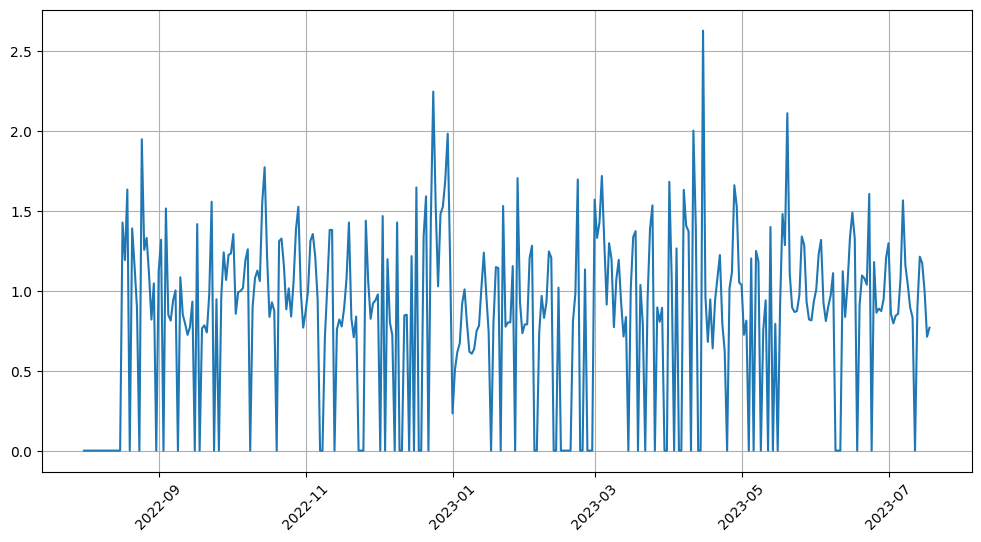

In [20]:
plt.figure(figsize=(12,6))
plt.plot(df_date)
plt.grid()
plt.xticks(rotation=45)
plt.show()

В качестве порога возьмём значение 1,7 это позволит уменьшить влияние выбросов, но приэтом оставит пики в праздничные дни

In [21]:
del df_date, new_dict, df_ts

Создадим функцию для обработки выбросов

In [22]:
def processing_outliers(df, column, threshold):
    df['rolling_mean_30'] = (df[column]
                           .shift()
                           .rolling(30)
                           .mean())
    df.loc[df['rolling_mean_30']==0, 'rolling_mean_30'] = 0.001 #защита от деления на 0
    df['ratio'] = df[column].shift() / df['rolling_mean_30']
    df.loc[df['ratio'] > threshold, column] = df.loc[df['ratio'] > threshold, 'rolling_mean_30'] * threshold
    df = df.drop(['ratio', 'rolling_mean_30'], axis=1)
    return df

Создадим функцию которая будет возвращать средню цену в определённый день за какое-то количество предшествующих недель, в дальнейшем будем получать данные за 4 недели.

In [23]:
def get_mean_in_day(df, weekday_column, column, n_week):
    list_weekday_column = df[weekday_column].unique()
    for day in list_weekday_column: 
        new_name_mean = f'mean_in_weekday_{n_week}_week'  
        df.loc[(df[weekday_column]==day), new_name_mean] = (df[df[weekday_column]==day][column]
                                                           .shift()
                                                           .rolling(n_week)
                                                           .mean())
    df = df.drop(weekday_column, axis=1)     
    return df

Создадим функцию для получения скользящих статистик по каждой из группировок

In [24]:
def get_rolling(df, column, n_day_list):    
    for n_day in n_day_list:
        new_name_mean = f'rolling_mean_{n_day}'
        new_name_max = f'rolling_max_{n_day}'
        new_name_min = f'rolling_min_{n_day}'        
        new_name_max_min = f'rolling_max_min_{n_day}'
        new_name_ratio = f'rolling_ratio_{n_day}'     
        df[new_name_mean] = (df[column]
                               .shift()
                               .rolling(n_day)
                               .mean())
        df[new_name_max] = (df[column]
                               .shift()
                               .rolling(n_day)
                               .max())
        df[new_name_min] = (df[column]
                               .shift()
                               .rolling(n_day)
                               .min())
        df[new_name_max_min] = (df[new_name_max] + df[new_name_min]) / 2
        
        df.loc[df[new_name_mean]==0, new_name_mean] = 0.001 #защита от деления на 0
        df[new_name_ratio] = df[new_name_max_min] / df[new_name_mean]
        df
    return df

Создадим функцию для получения лагов в каждой из группировок. Будем добавлять в датасет лаги в от 1 до 14 дней, затем также посчитаем среднее по лагам в 3 дня по смещениям.

In [25]:
def get_lag(df, column, n_day_list):
    for n_day in n_day_list:
        new_name = f'lag_{n_day}'
        df[new_name] = (df[column].shift(n_day)) 
        
#         df[f'mean_3_day_{n_day}lag'] = (df[column]
#                                        .shift(n_day)
#                                        .rolling(3)
#                                        .mean())
    df['mean_week_lag'] = df[['lag_5', 'lag_6', 'lag_7']].mean(axis=1)
    return df

Создадим функцию для обработки нового года, пасхи и праздников. 

In [26]:
def get_features_ny_e_h(df, list_holidays):
    #Добавим флаг нового года и пасхи
    df['new_year'] = df.index=='2023-01-01'
    df['easter'] = df.index=='2023-04-16'
    #
    df['week_after_new_year'] = (df.index > '2023-01-01') & (df.index <= '2023-01-08')
    df['week_after_easter'] = (df.index > '2023-04-16') & (df.index <= '2023-01-23')
    # Добавим флаг после нового года и пасхи
    df['week_befor_new_year'] = (df.index > '2022-12-24') & (df.index < '2023-01-01')
    df['week_befor_easter'] = (df.index > '2023-04-09') & (df.index <= '2023-04-16')

    #Обработаем список праздников
    df['holiday'] = df.index.isin(list_holidays)
    return df

Создадим список с праздничными днями с учётом переносов

In [27]:
list_holidays = [
    '2022-01-01',
    '2022-01-02',
    '2022-01-03',
    '2022-01-04',
    '2022-01-05',
    '2022-01-06',
    '2022-01-07',
    '2022-01-08',
    '2022-02-23',
    '2022-03-08',
    '2022-05-01',
    '2022-05-09',
    '2022-06-12',
    '2022-11-04',
    '2022-05-03',
    '2022-05-10',
    '2022-03-07', 
    '2023-01-01',
    '2023-01-02',
    '2023-01-03',
    '2023-01-04',
    '2023-01-05',
    '2023-01-06',
    '2023-01-07',
    '2023-01-08',
    '2023-02-23',
    '2023-03-08',
    '2023-05-01',
    '2023-05-09',
    '2023-06-12',
    '2023-11-04',
    '2023-02-24',
    '2023-05-08',
]

Сохраним данный список для дальнейшего использования в модели

In [28]:
df_holidays = pd.DataFrame({'holidays': list_holidays})
df_holidays.to_csv(PATH_TO_SAVE_HOLIDAYS, index=False)

Переименуем в таргет и добавим смещение в 14 дней 

In [29]:
def get_target_diapazon(df, column, n_day, is_train=True):
    df = df.copy(deep = True)
    df = df.rename(columns = {'pr_sales_in_units': 'target_0'})
    if is_train:
        for n_day in range(1, n_day):           
            new_name = f'target_{n_day}'
            df[new_name] = df['target_0'].shift(-n_day)
    return df

Напишем функцию, которая на вход будет принимать датасет, преобразовывать егов слоыварь, вызывать все функции, производить обратное преобразование из словаря и возвращать готовый датасет.

In [30]:
def get_features_for_ts(df, 
                        is_train = True, 
                        n_day_target = 14,
                        column = 'pr_sales_in_units',
                        weekday_column = 'weekday',
                        n_week_for_lag = 4,
                        n_day_rolling_list = [7, 14, 30],
                        n_day_lag_list = list(range(1,15)),
                        list_holidays = [],
                        drop_outliers = False, 
                        threshold = 1.7):
    print('Начата генерация признаков')
    df = df.copy(deep = True)
    df = get_group_and_agg(df, is_train) 
    new_dict = {}
    dict_df = get_dict(df, 'group_column')
    for x in tqdm(dict_df):
        df = dict_df[x].copy(deep = True)         
        if drop_outliers:
            df = processing_outliers(df, column, threshold)
        df = get_date_and_weekday(df)  
        df = get_mean_in_day(df, weekday_column, column, n_week_for_lag)
        df = get_rolling(df, column, n_day_rolling_list)
        df = get_lag(df, column, n_day_lag_list)
        df = get_features_ny_e_h(df, list_holidays)
        df = get_target_diapazon(df, column, n_day_target, is_train=is_train)        
        new_dict[x] = df
        
    return pd.concat(new_dict.values(),axis=0).sort_values(['date','group_column'])

In [31]:
df_ts = get_features_for_ts(sales_df_train, list_holidays=list_holidays)

Начата генерация признаков


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:05<00:00, 36.22it/s]


In [32]:
df_ts_no = get_features_for_ts(sales_df_train, list_holidays=list_holidays, drop_outliers = True)

Начата генерация признаков


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:06<00:00, 33.70it/s]


Выведем предобработанные датасеты

In [33]:
df_ts.head()

,st_id,group_cat,pr_sales_type_id,pr_uom_id,target_0,group_column,weekend,weekday_0,weekday_1,weekday_2,...,target_4,target_5,target_6,target_7,target_8,target_9,target_10,target_11,target_12,target_13
date,,,,,,,,,,,,,,,,,,,,,
2022-08-01,084a8a9aa8cced9175bd07bc44998e75,cat_12,0.0,False,0.000000,084a8a9aa8cced9175bd07bc44998e75_cat_12_0.0,False,True,False,False,...,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-08-01,084a8a9aa8cced9175bd07bc44998e75,cat_12,1.0,False,0.000000,084a8a9aa8cced9175bd07bc44998e75_cat_12_1.0,False,True,False,False,...,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-08-01,084a8a9aa8cced9175bd07bc44998e75,cat_4,1.0,True,0.000000,084a8a9aa8cced9175bd07bc44998e75_cat_4_1.0,False,True,False,False,...,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-08-01,16a5cdae362b8d27a1d8f8c7b78b4330,cat_10,0.0,True,1.833333,16a5cdae362b8d27a1d8f8c7b78b4330_cat_10_0.0,False,True,False,False,...,0.000000,0.000000,0.142857,0.625,0.428571,0.666667,0.500000,0.714286,0.714286,0.714286
2022-08-01,16a5cdae362b8d27a1d8f8c7b78b4330,cat_10,1.0,True,3.692308,16a5cdae362b8d27a1d8f8c7b78b4330_cat_10_1.0,False,True,False,False,...,4.230769,6.384615,3.818182,1.700,2.000000,3.750000,4.083333,2.333333,4.909091,3.666667


Сохраним полученный датасет

In [34]:
df_ts.to_csv(PATH_TO_SAVE_SALES_TRAIN_DF, index=False)

In [35]:
df_ts_no.to_csv(PATH_TO_SAVE_SALES_TRAIN_DF_NO_OTLIERS, index=False)

Добавим к обработанному датасету датасет по столбцам, поскольку данная информацию была утерена при группировке

## Предообработка данных по магазинам

Поскольку преобразования с данным датасетом нужно будет произвести только один, то для кодировки OHE можно использовать get_dummies, однако немного обернём его в функцию, чтобы названия столбцов были информативнее.

In [36]:
def get_ohe(df, column):    
    df_ohe = pd.get_dummies(df[column])
    new_columns = [f'{column}_{c}' for c in df_ohe.columns]
    df_ohe.columns = new_columns
    df = df.drop(column, axis=1)    
    df = pd.concat([df, df_ohe], axis=1)
    return df

Произведём кодировку признаков в датасете st_df

In [37]:
list_columns_for_ohe = ['st_city_id', 'st_division_code', 'st_type_format_id', 'st_type_loc_id', 'st_type_size_id']
for column in list_columns_for_ohe:
    st_df = get_ohe(st_df, column)

Оставим только активные  магазины и удалим столбец st_is_active

In [38]:
st_df = st_df[st_df['st_is_active']!=0]
st_df = st_df.drop('st_is_active', axis=1)

Добавим признак среднего количества проданных товаров в магазине

In [39]:
df_st_mean = (sales_df_train.groupby('st_id')['pr_sales_in_units'].agg('mean')
                  .reset_index(drop=False)
                  .sort_values(by='pr_sales_in_units'))

In [40]:
st_df = st_df.merge(df_st_mean, on ='st_id')

Преобразуем полученный столбец в признаки OHE, согласно выбранным диапазонам на EDA

In [41]:
st_df['mean_seale_1'] = st_df['pr_sales_in_units'] < 2.5
st_df['mean_seale_2'] = (st_df['pr_sales_in_units'] >= 2.5) & (st_df['pr_sales_in_units'] < 4)
st_df['mean_seale_3'] = (st_df['pr_sales_in_units'] >= 4) & (st_df['pr_sales_in_units'] < 5)
st_df['mean_seale_4'] = (st_df['pr_sales_in_units'] >= 5)
st_df = st_df.drop('pr_sales_in_units', axis=1)

Воспользуемся функциями написанной в EDA для получения скользящего среднего по всем ТЦ в датасете и рассчёта отношения летних продаж к зимним, чтобы можно было их разбить по группам

In [42]:
def get_df_ts_store(df, store_columns):
    df_st_id = df.groupby(['date',store_columns])['pr_sales_in_units'].agg('sum').reset_index(drop=False)
    df_st_id.index = df_st_id['date']
    df_st_id = df_st_id.drop('date', axis=1)
    return df_st_id

In [43]:
def get_rolling_mean(df, group_column, column):
    list_group_column = df[group_column].unique()
    for gr_col in list_group_column:
        new_name = f'rolling_mean_{column}'
        df.loc[df[group_column]==gr_col, new_name] = (df[df[group_column]==gr_col][column]
                                                                    .shift()
                                                                    .rolling(30)
                                                                    .mean())
    df = df.drop(column, axis=1)
    return df

In [44]:
def get_ratio_summer_winter(df):
    df_july = df.loc['2023-07-01'][['st_id', 'rolling_mean_pr_sales_in_units']]
    df_jan = df.loc['2023-01-01'][['st_id', 'rolling_mean_pr_sales_in_units']]
    new_df = df_july.merge(df_jan, on='st_id', how='left')
    new_df.loc[new_df['rolling_mean_pr_sales_in_units_y']==0, 'rolling_mean_pr_sales_in_units_y'] =0.01 #защита от деления на 0
    new_df['ratio_summer_winter'] = (new_df['rolling_mean_pr_sales_in_units_x']
                                     / new_df['rolling_mean_pr_sales_in_units_y'])
    return new_df[['st_id', 'ratio_summer_winter']]

In [45]:
df_st_id = get_df_ts_store(sales_df_train, 'st_id')
df_st_id = get_rolling_mean(df_st_id, 'st_id', 'pr_sales_in_units')

In [46]:
df_st_id_1 = df_st_id.groupby('st_id')['rolling_mean_pr_sales_in_units'].agg('max').reset_index(drop=False)
df_st_id_2 = get_ratio_summer_winter(df_st_id)
df_st_id = df_st_id_1.merge(df_st_id_2, on='st_id', how='left')

Добавим столбец отнесения магазина к той или иной группе

In [47]:
df_st_id.loc[df_st_id['rolling_mean_pr_sales_in_units']<500,'group_shop'] = 'group_1'
df_st_id.loc[df_st_id['ratio_summer_winter']>1,'group_shop'] = 'group_2'
df_st_id['group_shop'] = df_st_id['group_shop'].fillna('group_3')
df_st_id = df_st_id.drop(['rolling_mean_pr_sales_in_units', 'ratio_summer_winter'], axis=1)

Присоединим данный дф к датасету по магазинам

In [48]:
st_df = st_df.merge(df_st_id, on ='st_id')

Выведем получившийся датасет

In [49]:
st_df

,st_id,st_city_id_1587965fb4d4b5afe8428a4a024feb0d,st_city_id_3202111cf90e7c816a472aaceb72b0df,st_city_id_885fe656777008c335ac96072a45be15,st_city_id_908c9a564a86426585b29f5335b619bc,st_city_id_955d864a62659945cc9434898e275deb,st_city_id_b8b4b727d6f5d1b61fff7be687f7970f,st_city_id_c1f75cc0f7fe269dd0fd9bd5e24f9586,st_division_code_296bd0cc6e735f9d7488ebc8fbc19130,st_division_code_32586311f16876abf92901085bd87b99,...,st_type_size_id_12,st_type_size_id_19,st_type_size_id_20,st_type_size_id_28,st_type_size_id_32,mean_seale_1,mean_seale_2,mean_seale_3,mean_seale_4,group_shop
0,bd470ca955d9497bbcb808e59952fffc,False,False,False,False,True,False,False,False,False,...,False,True,False,False,False,True,False,False,False,group_1
1,6364d3f0f495b6ab9dcf8d3b5c6e0b01,False,False,False,False,False,True,False,False,False,...,True,False,False,False,False,True,False,False,False,group_3
2,1ecfb463472ec9115b10c292ef8bc986,False,False,False,True,False,False,False,False,False,...,False,False,False,True,False,True,False,False,False,group_1
3,16a5cdae362b8d27a1d8f8c7b78b4330,False,False,False,False,False,False,True,True,False,...,False,False,False,False,False,True,False,False,False,group_3
4,53e19f3dbb211f20b20b45668303c1b6,False,False,False,False,True,False,False,False,False,...,False,False,True,False,False,True,False,False,False,group_1
5,42a0e188f5033bc65bf8d78622277c4e,False,False,False,False,False,True,False,False,False,...,True,False,False,False,False,True,False,False,False,group_3
6,c81e728d9d4c2f636f067f89cc14862c,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,group_3
7,fa7cdfad1a5aaf8370ebeda47a1ff1c3,False,False,True,False,False,False,False,True,False,...,True,False,False,False,False,True,False,False,False,group_3
8,f7e6c85504ce6e82442c770f7c8606f0,False,True,False,False,False,False,False,False,True,...,True,False,False,False,False,True,False,False,False,group_2
9,084a8a9aa8cced9175bd07bc44998e75,False,True,False,False,False,False,False,False,True,...,False,True,False,False,False,True,False,False,False,group_2


Столбец st_city_id_1587965fb4d4b5afe8428a4a024feb0d можно удалить, поскольку он содержит одинаковые значения

In [50]:
st_df = st_df.drop('st_city_id_1587965fb4d4b5afe8428a4a024feb0d', axis=1)

Сохраним датасет

In [51]:
st_df.to_csv(PATH_TO_SAVE_ST_DF, index=False)

## Создание финального датасета

Напишем функцию для объединения датасетов магазинов и покупок.

In [52]:
def combine_shops_sales(st_df, df_ts, is_train=True):
    #объединим получившиеся датасеты, перезададим индексы и удалим пропуски в отсутсвующих торговых центрах
    df = df_ts.merge(st_df, on ='st_id', how='left')
    df.index = df_ts.index
    df = df.dropna(subset='group_shop')
    # Создадим столбец с уникальным сочитанием группы магазина и группы категории товра 
    # удалим ненужные столбцы и пропуски в данных
    df['group_shop_cat'] = df['group_shop'] + '_' + df['group_cat']
    if is_train:
        df = df.drop(['st_id', 'group_cat', 'group_column', 'group_shop'], axis=1)
    else:
        df = df.drop(['group_cat', 'group_column', 'group_shop'], axis=1)
    df = df.dropna()
    return df

In [53]:
df_train = combine_shops_sales(st_df, df_ts)

df_train_no = combine_shops_sales(st_df, df_ts_no)

In [54]:
df_train.to_csv(PATH_TO_SAVE_TRAIN_DF)

df_train_no.to_csv(PATH_TO_SAVE_TRAIN_DF_NO_OTLIERS)

## Создание объединённой функции препроцессинга

Создадим объединённую функцию, которая на вход будет принимать сырые данные по продажам, обработанные данные по категориям товаров для ML модели, обработанные данные по торговым центрам и возвращать обработанный датасет

In [55]:
def preproceccing_df(df, 
                     pr_df, 
                     st_df, 
                     is_train = True, 
                     n_day_target = 14,
                     column = 'pr_sales_in_units',
                     weekday_column = 'weekday',
                     n_week_for_lag = 4,
                     n_day_rolling_list = [7, 14, 30],
                     n_day_lag_list = list(range(1,15)),
                     list_holidays = [],
                     drop_outliers = False, 
                     threshold = 1.7):
    
    df = df[['st_id', 'pr_sales_type_id', 'pr_sku_id', 'date', 'pr_sales_in_units']]
    df = df.merge(pr_df, on ='pr_sku_id')
    df = get_features_for_ts(df, 
                             is_train = is_train, 
                             n_day_target = n_day_target,
                             column = column,
                             weekday_column = weekday_column,
                             n_week_for_lag = n_week_for_lag,
                             n_day_rolling_list = n_day_rolling_list,
                             n_day_lag_list = n_day_lag_list,
                             list_holidays = list_holidays,
                             drop_outliers = drop_outliers, 
                             threshold = threshold)
    if not is_train:
        df['date'] = df.index
        pr_df = pr_df.drop('pr_uom_id', axis=1)
        df = df.merge(pr_df, on ='pr_sku_id')
        df = df.sort_values(['date', 'st_id', 'pr_sku_id'])
        df.index = df['date']
        df = df.drop('date', axis=1)
    df = combine_shops_sales(st_df, df, is_train)
    return df

Протестируем ей работу на данных для теста

In [56]:
%%time
sales_df_train = pd.read_csv(PATH_TO_SAVE_CLEAR_TRAIN_DF)
df_test = preproceccing_df(sales_df_train[sales_df_train['date']>'2023-05-15'], 
                           pr_df, 
                           st_df, 
                           list_holidays = list_holidays, 
                           is_train=False)

Начата генерация признаков


100%|██████████████████████████████████████████████████████████████████████████████| 9679/9679 [03:45<00:00, 42.87it/s]


CPU times: total: 6min 35s
Wall time: 6min 35s


In [57]:
%%time
sales_df_train = pd.read_csv(PATH_TO_SAVE_CLEAR_TRAIN_DF)
df_test_no = preproceccing_df(sales_df_train[sales_df_train['date']>'2023-05-15'], 
                               pr_df, 
                               st_df, 
                               list_holidays = list_holidays, 
                               is_train=False,
                               drop_outliers = True)

Начата генерация признаков


100%|██████████████████████████████████████████████████████████████████████████████| 9679/9679 [04:05<00:00, 39.37it/s]


CPU times: total: 7min 6s
Wall time: 7min 5s


Сохраним получившиеся датасеты

In [58]:
df_test.to_csv(PATH_TO_SAVE_TEST_DF)

df_test_no.to_csv(PATH_TO_SAVE_TEST_DF_NO_OTLIERS)

## Выводы

В данном разделе была проведена прдобработка данных в ходе которой:
1. Произведено преобразование кодов товаров в категории согласно EDA для дальнейшего обуечние моделей
2. Созданы признаки для временного ряда (лаги, скользящие среднии, выделены дни недели, созданы флаги для выходных и праздничных дней, и ряд других признаков)
3. Почищены данные от выбрасов.
4. Проведено преобразование по информации о магазинах, удалены неактивные.
5. Создан отдельный столбец для выбора конкретной модели для конкретного временного ряда.
6. Созданы функции, позволяющие автоматизировать процес предообработки данных.